In [37]:
import os
import logging
from time import time, localtime
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import numpy as np
from utils import plot_graph
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras import losses, metrics, optimizers
import random
import pandas as pd
import sys
import matplotlib.pyplot as plt
import nest_asyncio
from pathlib import Path
from checkpoint_manager import FileCheckpointManager
import tensorflow_addons as tfa
nest_asyncio.apply()
SEED = 1337
tf.random.set_seed(SEED)

def train_test_split(df, frac=0.2):
    selected = df['flow_id'].drop_duplicates().sample(frac=frac)
    test = df[df['flow_id'].isin(selected)]
    train = df[~df['flow_id'].isin(selected)]
    return train, test


Lựa chọn model <br>
Thay models.<Ten_model>

In [38]:
from models.CNNv6 import create_keras_model


Thay đổi các siêu tham số trong cell dưới <br>
**experiment_name:** Tên bộ dữ liệu được sử dụng, <Tên dữ liệu>_<Số byte sử dụng> <br>
**method:** Mô hình sử dụng <br>
**client_lr, server_lr:** Learning rate của client và server, khi fine tune bắt đầu từ 1 và giảm dần xuống 3e-4 <br>
**NUM_ROUNDS:** Số vòng lặp (Bắt đầu từ 1 và tăng dần lên 3000 nếu mô hình chưa hội tụ - 1/100/200/300/400/500/.../3000) <Br>
**BATCH_SIZE:** Kích thước batch (Bắt đầu từ 8 và tăng dần lên 64) 8/16/32/64 <br>
**split:** Để nguyên là 5

byte_number (string): Cac byte cua packet, bao gom 10, 32, 64, 128, 256, 512, 1024, 1460

In [39]:
byte_number = "512"


In [40]:
experiment_name = "GQUIC_" + byte_number
method = "nonFL_CNNv6_W_FS"
client_lr = 3e-4
NUM_ROUNDS = 10
BATCH_SIZE = 16


In [41]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method
output_dir = this_dir / "sdn_results" / experiment_name / method

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)


In [42]:
def sec_to_hours(seconds):
    a = seconds//3600
    b = (seconds % 3600)//60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d


In [43]:
def most_frequent(List):
    return max(set(List), key=List.count)


### Đọc dữ liệu

In [44]:
# train_dir = '/home/onos/FL/Data_Processing/GQUIC_small/Train/GQUIC_data_' + byte_number + '.feather'
# test_dir = '/home/onos/FL/Data_Processing/GQUIC_small/Test//GQUIC_test_' + byte_number + '.feather'
train_dir = '/home/onos/FL/Data_Processing/GQUIC_data.feather'
test_dir = '/home/onos/FL/Data_Processing/GQUIC_test.feather'
data = pd.read_feather(train_dir)
test = pd.read_feather(test_dir)


In [45]:
# data.drop(['length'],axis=1,inplace=True)
# test.drop(['length'],axis=1,inplace=True)


In [46]:
data, val = train_test_split(data,frac=0.2)

In [47]:
result = test.groupby('flow_id')['Label'].apply(list).to_dict()
flow_label = []
for flow in result:
    flow_label.append(most_frequent(result[flow]))

In [48]:
true_test = test.drop('flow_id', axis=1)
true_data = data.drop('flow_id', axis=1)
true_val = val.drop('flow_id',axis=1)

In [49]:
NUM_FEATURE = len(true_test.columns)-1
NUM_CLASSES = len(np.unique(true_test['Label']))
print(NUM_FEATURE, NUM_CLASSES)


1460 4


In [50]:
# y = true_data['Label']
# X = true_data.drop(['Label'], axis=1)

In [51]:
# from sklearn.feature_selection import SelectKBest
# selector = SelectKBest( k = int(byte_number))
# selector.fit(X, y)
# X.columns[selector.get_support()]

In [52]:
# feature_selected = X.columns[selector.get_support()].to_list()

In [53]:
y_test = true_test['Label'].to_numpy()
x_test = true_test.drop(['Label'],axis=1).to_numpy()
y_train = true_data['Label'].to_numpy()
x_train = true_data.drop(['Label'],axis=1).to_numpy()
y_val = true_val['Label'].to_numpy()
x_val = true_val.drop(['Label'],axis=1).to_numpy()

In [54]:
# NUM_FEATURE = len(feature_selected)

In [55]:
# def sklearn_to_df(sklearn_dataset):
#     df = pd.DataFrame(sklearn_dataset.data,
#                       columns=sklearn_dataset.feature_names)
#     df['Label'] = pd.Series(sklearn_dataset.Label)
#     return df


In [56]:
# from sklearn import datasets
# df = sklearn_to_df(datasets.load_iris())


In [57]:
# train_data = train_data[0].concatenate(train_data[1])
# val_data = val_data[0].concatenate(val_data[1])


### Model Definition

In [58]:
model = create_keras_model(NUM_FEATURE, NUM_CLASSES)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1460, 32)          64        
                                                                 
 dropout_2 (Dropout)         (None, 1460, 32)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 487, 32)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 15584)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                498720    
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                      

In [59]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=client_lr), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
start = time()
history = model.fit(x_train, y_train, epochs=NUM_ROUNDS, batch_size=BATCH_SIZE,use_multiprocessing=True,shuffle=False,validation_data=(x_val,y_val))
end = time() - start

Epoch 1/10
11123/11123 [==============================] - 80s 7ms/step - loss: 16.9182 - accuracy: 0.7115 - val_loss: 10.3228 - val_accuracy: 0.1484
Epoch 2/10
11123/11123 [==============================] - 82s 7ms/step - loss: 0.9691 - accuracy: 0.6263 - val_loss: 17.7019 - val_accuracy: 0.1484
Epoch 3/10
11123/11123 [==============================] - 91s 8ms/step - loss: 0.9894 - accuracy: 0.6330 - val_loss: 18.1863 - val_accuracy: 0.1484
Epoch 4/10
11123/11123 [==============================] - 108s 10ms/step - loss: 0.9596 - accuracy: 0.6318 - val_loss: 20.7301 - val_accuracy: 0.1484
Epoch 5/10
11123/11123 [==============================] - 94s 8ms/step - loss: 0.9740 - accuracy: 0.6331 - val_loss: 21.6480 - val_accuracy: 0.1484
Epoch 6/10
11123/11123 [==============================] - 85s 8ms/step - loss: 0.9736 - accuracy: 0.6339 - val_loss: 18.6077 - val_accuracy: 0.1484
Epoch 7/10
11123/11123 [==============================] - 90s 8ms/step - loss: 0.9546 - accuracy: 0.6334 - va

In [60]:
total_time = "Time: {}".format(sec_to_hours(end))
print(total_time)


Time: 0 hours 14 mins 45 seconds


### Evaluation

In [61]:
best_model_accuracy = history.history['accuracy'][np.argmin(history.history['loss'])]

In [62]:
_, test_acc = model.evaluate(x_test, y_test,verbose=2, batch_size=BATCH_SIZE,use_multiprocessing=True)

3475/3475 - 7s - loss: 17.5415 - accuracy: 0.1568 - 7s/epoch - 2ms/step


In [63]:
train_val = str(round(best_model_accuracy*100)) + "_" + str(round(test_acc*100))

In [64]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method / train_val
output_dir = this_dir / "sdn_results" / experiment_name / method / train_val

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)

In [65]:
model.save(model_dir/'model.h5')

In [66]:
with open(output_dir/'parameters.txt', 'w') as f:
    print('client_lr: {}\nEpochs: {}\nBATCH_SIZE: {}'.format(
        client_lr, NUM_ROUNDS, BATCH_SIZE), file=f)
    f.close()

In [67]:
text_file = open(output_dir/"time.txt", "w")
n = text_file.write(total_time)
text_file.close()

In [68]:
predictions = model.predict(x_test,verbose=2,use_multiprocessing=True,batch_size=BATCH_SIZE)

3475/3475 - 7s - 7s/epoch - 2ms/step


In [69]:
y_pred = np.argmax(predictions, axis=-1)
test['pred'] = y_pred.tolist()

In [70]:
result = test.groupby('flow_id')['pred'].apply(list).to_dict()
flow_pred = []
for flow in result:
    flow_pred.append(most_frequent(result[flow]))

In [71]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


classes = []
for c in range(NUM_CLASSES):
    classes.append("Class {}".format(c))
print(classes)
with open(output_dir/'metrics.txt', 'w') as f:
    confusion = confusion_matrix(flow_label, flow_pred)
    print('Confusion Matrix\n', file=f)
    print(confusion, file=f)

    # importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(
        accuracy_score(flow_label, flow_pred)), file=f)

    print('Micro Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='micro')), file=f)
    print('Micro Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='micro')), file=f)
    print(
        'Micro F1-score: {:.2f}\n'.format(f1_score(flow_label, flow_pred, average='micro')), file=f)

    print('Macro Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='macro')), file=f)
    print('Macro Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='macro')), file=f)
    print(
        'Macro F1-score: {:.2f}\n'.format(f1_score(flow_label, flow_pred, average='macro')), file=f)

    print('Weighted Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='weighted')), file=f)
    print('Weighted Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='weighted')), file=f)
    print(
        'Weighted F1-score: {:.2f}'.format(f1_score(flow_label, flow_pred, average='weighted')), file=f)

    print('\nClassification Report\n', file=f)
    print(classification_report(flow_label, flow_pred, target_names=classes), file=f)
    f.close()


['Class 0', 'Class 1', 'Class 2', 'Class 3']


/home/onos/FL/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onos/FL/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onos/FL/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onos/FL/venv/lib/python3.9/site-packages/sklearn/metrics/_class

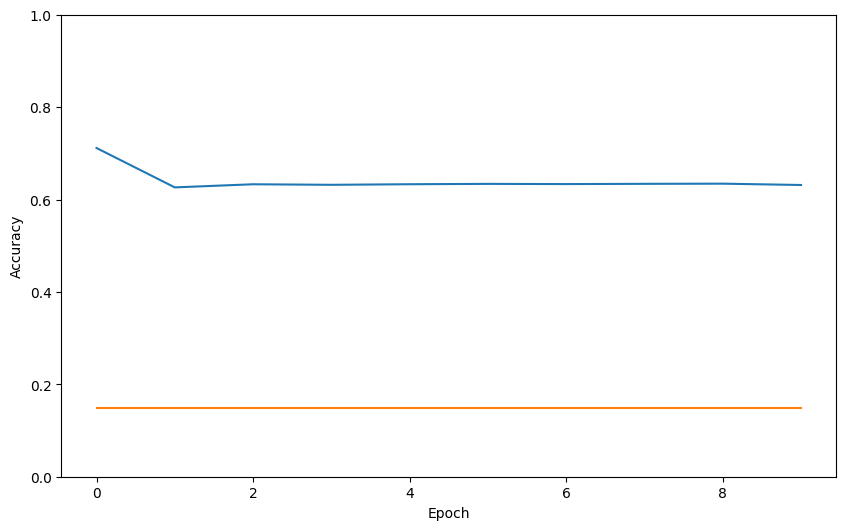

In [72]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.savefig(output_dir / "normal_model_Accuracy.png")